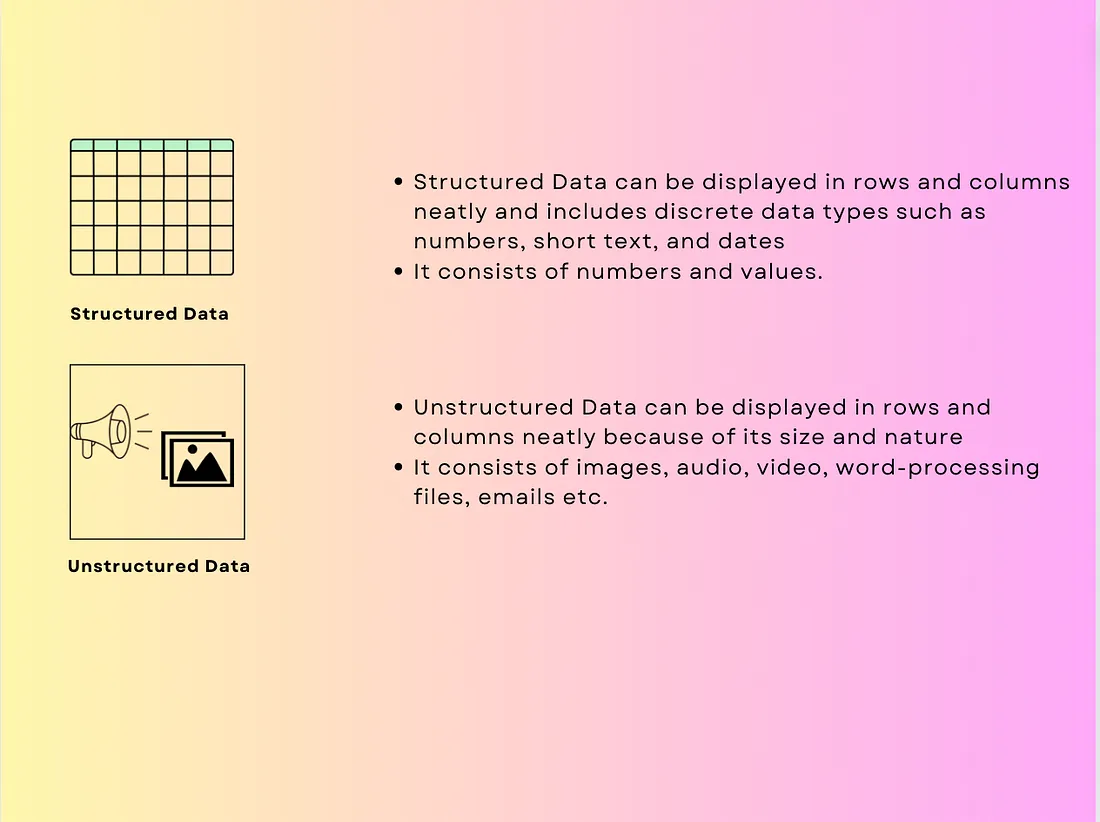

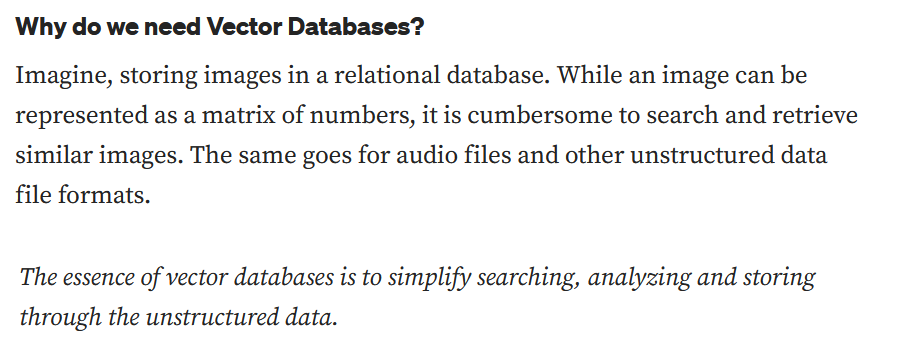

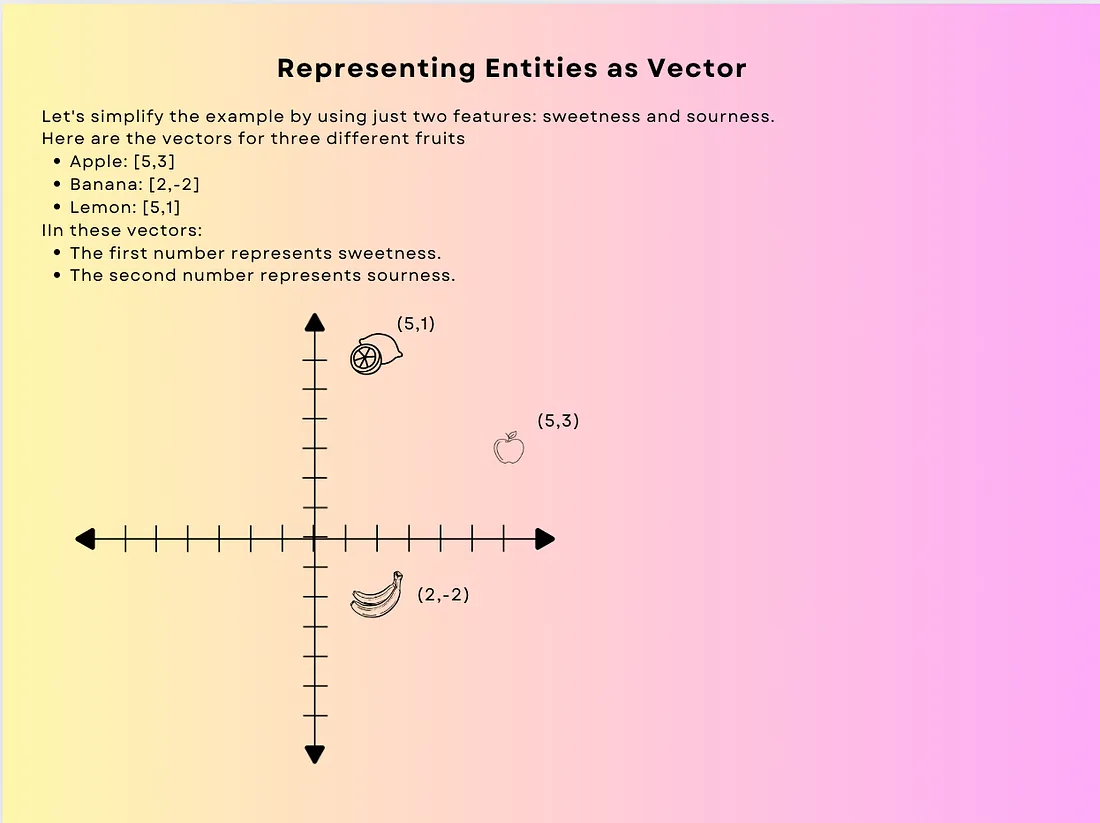

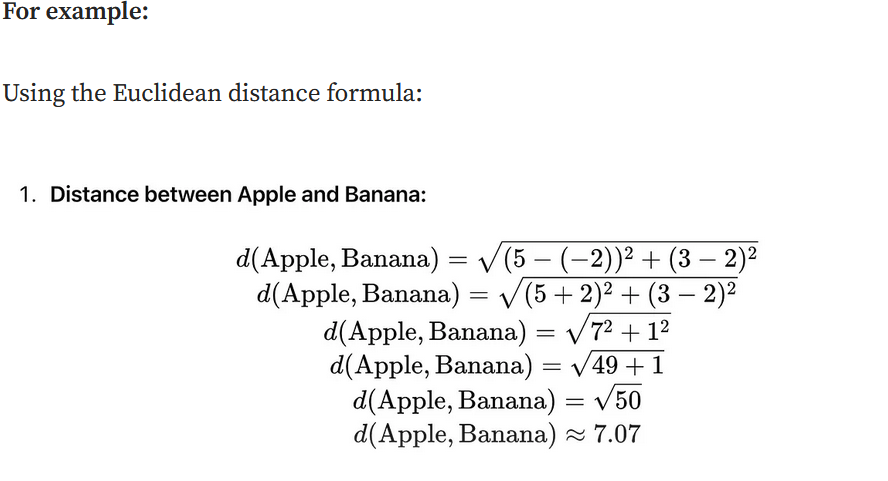

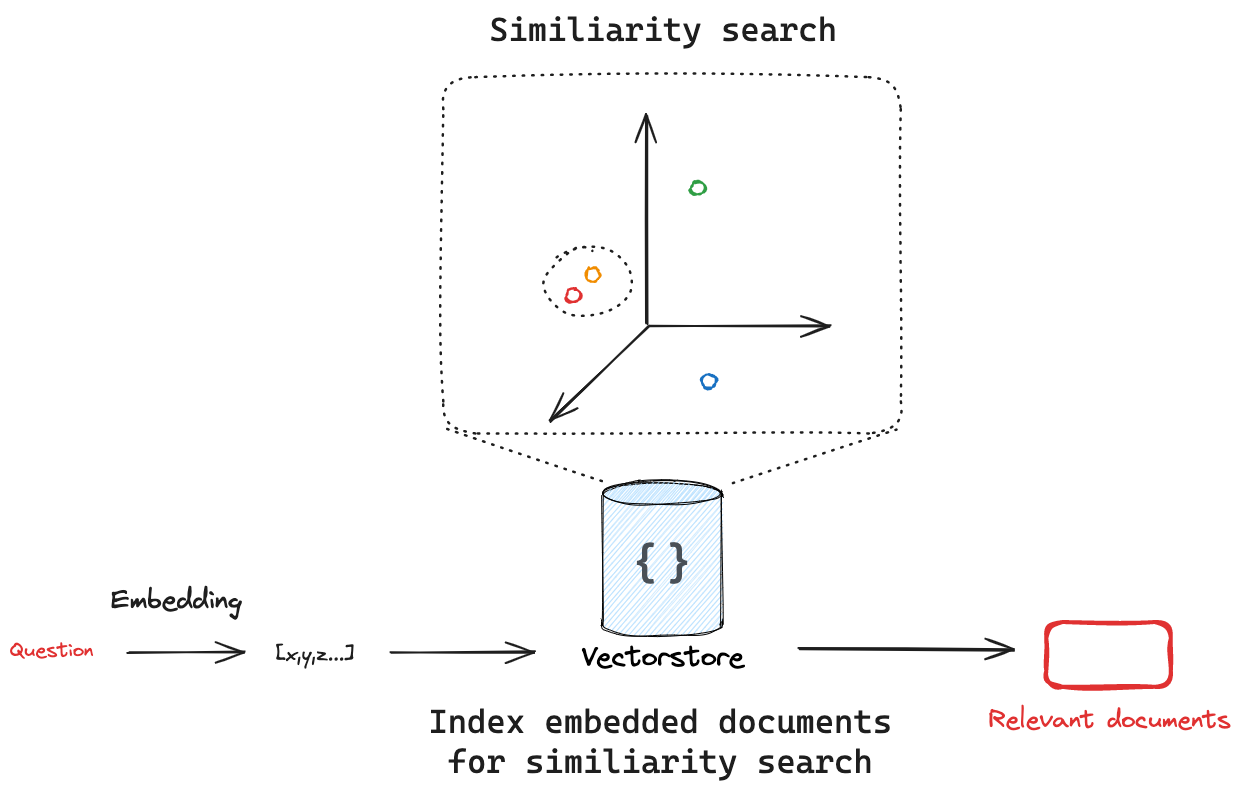

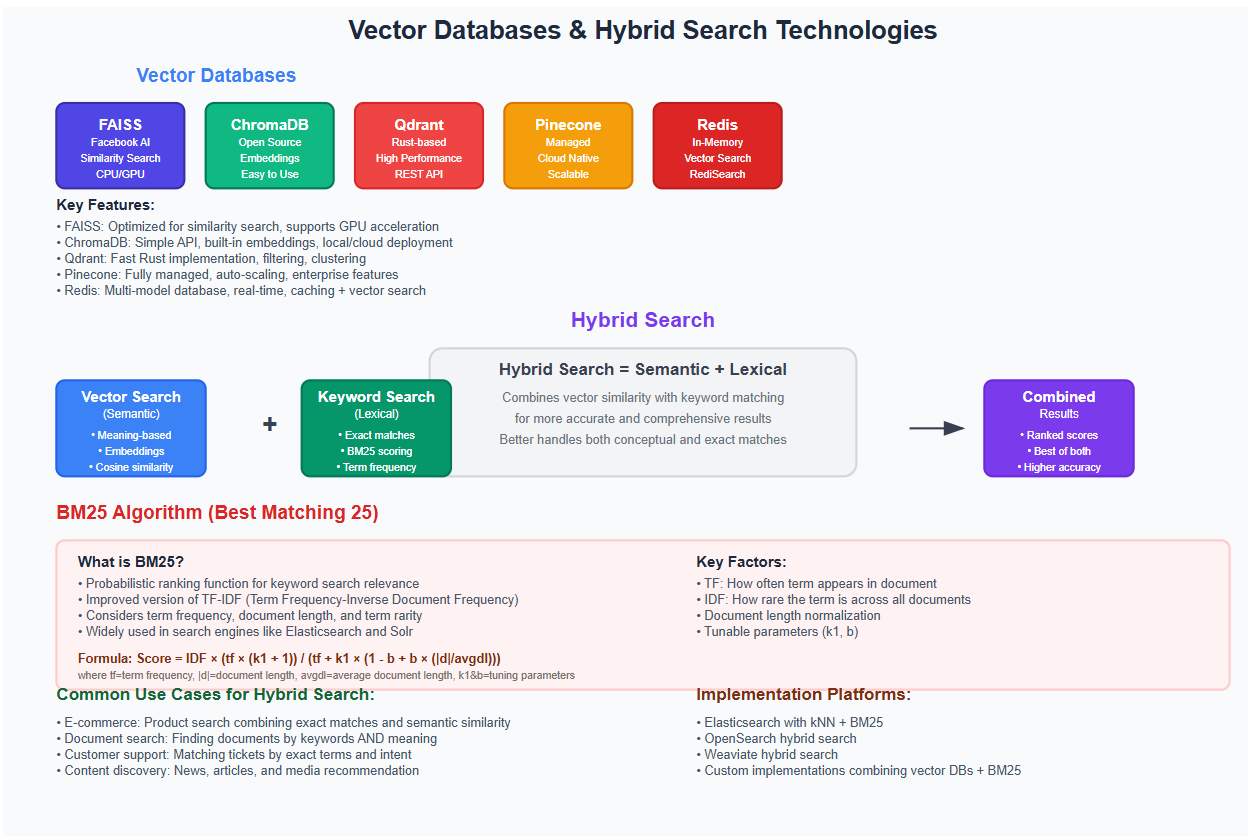

In [ ]:
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,420 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,759 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages 

In [ ]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

In [ ]:
!ollama pull all-minilm

In [ ]:

! pip install langchain-redis
! pip install qdrant_client
! pip install pinecone-client
! pip install redis
! pip install langchain langchain-core langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.3/152.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install ollama

In [ ]:
import ollama
v=ollama.embeddings(model='all-minilm', prompt='The sky is blue because of Rayleigh scattering')

In [ ]:
print(len(v['embedding']))

384


# 🧠 Vector Databases & Redis Chat Memory (with LangChain + Ollama Embeddings)

This notebook covers the fundamentals and practical usage of popular vector databases and Redis for chat history. It includes detailed examples for:

- FAISS (Facebook AI Similarity Search)
- ChromaDB
- Pinecone
- Qdrant
- Redis for Chat History (via LangChain)
- Embeddings via Ollama (all-MiniLM)


## 📌 What Are Vector Databases?

Vector databases store and search vector representations (embeddings) of documents or data points. These embeddings allow similarity-based retrieval, crucial for RAG (Retrieval-Augmented Generation), semantic search, recommendation systems, etc.


## 🔢 Understanding Embedding Dimensions (e.g., 384)

- The dimensionality of vectors (e.g., 384 for MiniLM) corresponds to the size of the embedding output by the model.
- Using Ollama with `all-minilm`, you get 384-dimensional embeddings.
- All vectors stored in a vector DB **must** have the same dimensionality.


## 🧩 Document Chunking

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://en.wikipedia.org/wiki/LangChain")
documents = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
chunks = splitter.split_documents(documents)


In [ ]:
len(chunks)

42

In [ ]:
chunks[:5]

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia', 'language': 'en'}, page_content='LangChain - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact us\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload fileSpecial pages\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAppearance\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDonate\n\nCreate account\n\nLog in\n\n\n\n\n\n\n\n\nPersonal tools\n\n\n\n\n\nDonate Create account Log in'),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia', 'language': 'en'}, page_content='Pages for logged out editors learn more\n\n\n\nContributionsTalk\n\n\n\n\n

## ⚡ FAISS with Ollama Embeddings

In [ ]:
docs = chunks

-----
FAISS

Overview:

Local, in-memory, extremely fast.

No persistence by default.

Good for prototyping or local apps.

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 44.9 MB/s eta 0:00:00


In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings

# Use Ollama with all-minilm embedding model (make sure Ollama is running)
embedding = OllamaEmbeddings(model="all-minilm")

faiss_db = FAISS.from_documents(docs, embedding=embedding)


# Save to disk
faiss_db.save_local("faiss_index")

# Load back
db = FAISS.load_local("faiss_index", embedding,allow_dangerous_deserialization=True)


## Metadata Filtering

In [ ]:
results = db.similarity_search_with_score("What is LangChain?", k=5, filter={"source": "https://en.wikipedia.org/wiki/LangChain"})
results

[(Document(id='6bd55155-afd9-41e3-aa18-9f649c7565eb', metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia', 'language': 'en'}, page_content='^ "Document Loaders ‚Äî LangChain 0.0.142". python.langchain.com. Archived from the original on 2023-04-18. Retrieved 2023-04-18.\n\n\nExternal links[edit]\n\n\nLangChain  at Wikipedia\'s sister projects\n\nMedia from CommonsData from Wikidata'),
  np.float32(22.891403)),
 (Document(id='e102f4f2-13dd-4b61-8782-cee14b450d49', metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia', 'language': 'en'}, page_content="Free and open-source software portal\nLangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

In [ ]:
db.similarity_search("What is LangChain?", k=2)

[Document(id='6bd55155-afd9-41e3-aa18-9f649c7565eb', metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia', 'language': 'en'}, page_content='^ "Document Loaders ‚Äî LangChain 0.0.142". python.langchain.com. Archived from the original on 2023-04-18. Retrieved 2023-04-18.\n\n\nExternal links[edit]\n\n\nLangChain  at Wikipedia\'s sister projects\n\nMedia from CommonsData from Wikidata'),
 Document(id='e102f4f2-13dd-4b61-8782-cee14b450d49', metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia', 'language': 'en'}, page_content="Free and open-source software portal\nLangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.[2]")]

In [ ]:
!pip install rank_bm25

⚡ FAISS – Hybrid Search

FAISS by itself only supports vector similarity search, but you can simulate hybrid search by combining it with:

    Metadata filtering

    BM25 search (e.g., via Whoosh or Elasticsearch)

    Then merge results manually or by score.

In [ ]:
from rank_bm25 import BM25Okapi



# BM25 Setup
texts = [doc.page_content for doc in docs]
tokenized_corpus = [t.split(" ") for t in texts]
bm25 = BM25Okapi(tokenized_corpus)

query = "What is LangChain?"
bm25_scores = bm25.get_scores(query.split(" "))

# Get top N BM25 results
top_n = 2
bm25_ranks = sorted(enumerate(bm25_scores), key=lambda x: x[1], reverse=True)[:top_n]
bm25_docs = [docs[i[0]] for i in bm25_ranks]

# Get top FAISS results
faiss_docs = faiss_db.similarity_search(query, k=2)

# Merge & deduplicate
combined_docs = list({doc.page_content: doc for doc in (bm25_docs + faiss_docs)}.values())

In [ ]:
len(combined_docs)

3

In [ ]:
# doc1s=[............] , docs2=[....................], [............]
#  Document(metadat="Argri",Page)

In [ ]:

# Insert
faiss_db.add_texts(["New text to insert"])


['a7f7e2f7-2557-4c53-bbcd-41ef2290593e']

## 📦 ChromaDB

Overview:

Lightweight, local-first vector DB.

Stores documents + metadata.

Easy to use for RAG and quick POCs.

In [ ]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 12.0 MB/s 

In [ ]:
from langchain_community.vectorstores import Chroma

chroma_db = Chroma.from_documents(docs, embedding, persist_directory="chroma_store")
chroma_db.add_texts(["Another document"], metadatas=[{"source": "manual"}])



['4dddf5d7-9c15-4e02-8ed9-0fbd2e69a228']

In [ ]:
chroma_db.similarity_search("What is LangChain?", k=2)

[Document(metadata={'title': 'LangChain - Wikipedia', 'language': 'en', 'source': 'https://en.wikipedia.org/wiki/LangChain'}, page_content='^ "Document Loaders ‚Äî LangChain 0.0.142". python.langchain.com. Archived from the original on 2023-04-18. Retrieved 2023-04-18.\n\n\nExternal links[edit]\n\n\nLangChain  at Wikipedia\'s sister projects\n\nMedia from CommonsData from Wikidata'),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'language': 'en', 'title': 'LangChain - Wikipedia'}, page_content="Free and open-source software portal\nLangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.[2]")]

In [ ]:
chroma_db.get("c672ec27-d1a5-453f-8f0e-08a1a46dd768")

{'ids': [],
 'embeddings': None,
 'documents': [],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': []}

In [ ]:
# Access the underlying Chroma client collection
collection = chroma_db._collection

# Get all IDs
all_ids = collection.get(include=[])["ids"]

print("All ChromaDB Document IDs:", all_ids)

All ChromaDB Document IDs: ['4e0d1d41-9f2a-4752-8720-20bee494d25f', '2f3fba2c-80a5-4a60-ac18-080de49707db', 'b81a2a31-c6d6-41be-8b45-d95c77b836c3', '48db8d58-34e3-4f5d-9c06-a928ac322908', '8b9b9467-ae1c-44d2-9a75-cc92caab613e', '02946120-fa04-485a-adcf-36f8d51ae689', 'daa321de-4ea3-459d-97b6-58a8d9a974f2', '37628e4a-6539-41b4-aed0-83fd9f761ad1', 'e8dcb421-d5c6-4c5f-8bd6-850f80e12b51', '0d9e6eeb-1b88-4bca-b425-1fce71dffa83', '696cd9e8-8d17-460d-ad79-4d2b27a2c957', 'b023cfc3-3959-4114-92ea-b2a29f071d19', 'a7bd771b-1527-4d91-a372-e2d069f5357c', '1d2d03cc-7e15-4596-9821-a4af45efb359', 'df062a9b-9736-4448-aa9c-7c504152c690', 'a9436f38-46ed-49f9-bf65-4807ab79b027', '411a2ddc-21cf-4c40-887d-2354e8d71fd9', '25f02328-13bd-40b8-9e3c-858ebc4fadf0', '05a26f36-403c-4f00-8023-7f63dd9680dd', 'd1c67435-8ad1-445d-a819-09542ea4de6b', 'c4b76304-e7b6-4472-a9eb-418d76027718', 'd9cdc125-7043-40e7-8533-a19443eecd6f', '59554b0a-bb02-429b-8685-a030f1049a41', '070d66d7-a801-4098-9562-9576d489f1e1', 'cff1bebf-08

In [ ]:
chroma_db.delete(["c672ec27-d1a5-453f-8f0e-08a1a46dd768"])

In [ ]:
chroma_db.get("c672ec27-d1a5-453f-8f0e-08a1a46dd768")

{'ids': [],
 'embeddings': None,
 'documents': [],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': []}

## Metadata Filtering

In [ ]:
results = chroma_db.similarity_search("what is langchain?", filter={"source": "https://en.wikipedia.org/wiki/LangChain"})
results

[Document(metadata={'language': 'en', 'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia'}, page_content='^ "Document Loaders ‚Äî LangChain 0.0.142". python.langchain.com. Archived from the original on 2023-04-18. Retrieved 2023-04-18.\n\n\nExternal links[edit]\n\n\nLangChain  at Wikipedia\'s sister projects\n\nMedia from CommonsData from Wikidata'),
 Document(metadata={'language': 'en', 'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia'}, page_content="Free and open-source software portal\nLangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.[2]"),
 Document(metadata={'language': 'en', 'title': 'LangChain - Wikipedia', 'source': 'https://en.wikipedia.org

## Hybrid Search

In [ ]:
Vector Database -> Sem + Keyboard
Redis -> Chat History

In [ ]:
from rank_bm25 import BM25Okapi

texts = [doc.page_content for doc in docs]
tokenized = [text.split() for text in texts]
bm25 = BM25Okapi(tokenized)

query = "what is langchain?"
bm25_scores = bm25.get_scores(query.split())
bm25_ranks = sorted(enumerate(bm25_scores), key=lambda x: x[1], reverse=True)[:5]
bm25_docs = [docs[i[0]] for i in bm25_ranks]

# Vector similarity
vector_docs = chroma_db.similarity_search(query, k=5)

# Combine
hybrid_docs = list({doc.page_content: doc for doc in (bm25_docs + vector_docs)}.values())


In [ ]:
hybrid_docs

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia', 'language': 'en'}, page_content='This page was last edited on 22 June 2025, at 02:48\xa0(UTC).\nText is available under the Creative Commons Attribution-ShareAlike 4.0 License;\nadditional terms may apply. By using this site, you agree to the Terms of Use and Privacy Policy. Wikipedia¬Æ is a registered trademark of the Wikimedia Foundation, Inc., a non-profit organization.\n\n\nPrivacy policy\nAbout Wikipedia\nDisclaimers\nContact Wikipedia\nCode of Conduct\nDevelopers\nStatistics\nCookie statement\nMobile view\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch'),
 Document(metadata={'language': 'en', 'source': 'https://en.wikipedia.org/wiki/LangChain', 'title': 'LangChain - Wikipedia'}, page_content="Free and open-source software portal\nLangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration fram

## 🧠 Redis for Chat History

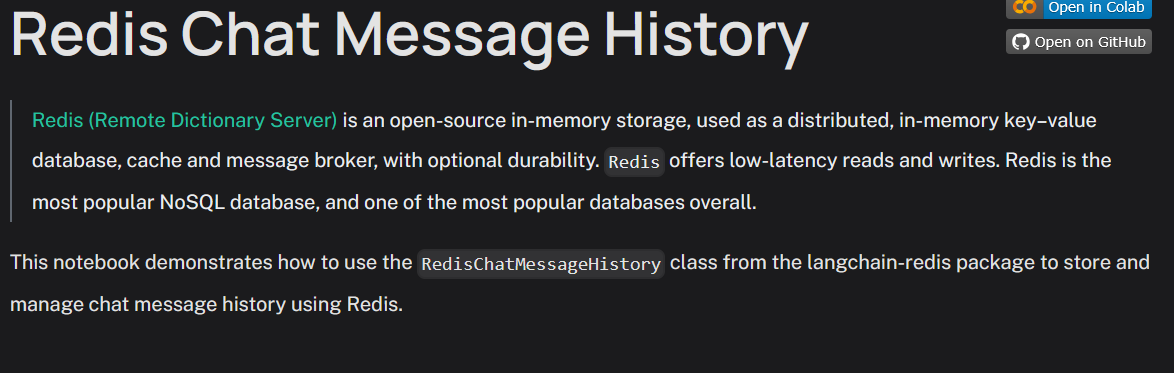

https://python.langchain.com/docs/integrations/memory/redis_chat_message_history/

In [ ]:
# from langchain_redis import RedisChatMessageHistory

# history = RedisChatMessageHistory(session_id="session1", redis_url="redis://localhost:6380")
# history.add_user_message("Hello")
# history.add_ai_message("Hi there!")
# print(history.messages)
# history.clear()

## 🏁 Choosing the Right Vector DB

| Database | Best For | Pros | Cons |
|----------|----------|------|------|
| FAISS | Local dev, prototypes | Fast, free | No persistence, no metadata filtering |
| Chroma | Lightweight RAG apps | Easy to use | Not for large-scale prod |
| Pinecone | Production apps | Managed, scalable | Requires account, costs |
| Qdrant | Filtering + scale | OSS + hosted options | More setup |


## ✅ Summary

- Chunk docs ✂️ before embedding.
- Use LangChain + vector DB for RAG pipelines.
- Redis is ideal for storing chat history.
- Ollama with all-MiniLM is a fast, local alternative to OpenAI for embeddings.
- Choose DB based on your **scale, budget, and control needs**.
